In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In data_analysis_impact_weather.ipynb I show that weather conditions may have a strong impact on foot traffic.
Hence, the question arises wether it is possible to predict foot traffic using weather data as predictors. As we
know that the impact of weather conditions depends on the season, it is recommended to built separate models
for different months. Here, I focus on the summer months July and August. Note, that only preliminary results are shown
to simply demonstrate the potential of predicting foot traffic.

In [32]:
# read daily foot traffic data: ftraffic = foot traffic; ltr = pedestrians crossing from left to right;
# rtl = pedestrians crossing from right to left; dow = day of week; month = month; s_holid = school holidays
# p_holid = public holidays; br_mo = bridge day Monday; br_fr = bridge day Friday; bweek = black week; fest = city festivals
df = pd.read_csv('DATA/foottraffic_daily_schoenbornstr_prep.csv',parse_dates=['date'])
display(df.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest
0,2020-01-01,7285.0,NaN,NaN,Wednesday,January,1,1,0,0,0,0
1,2020-01-02,40406.0,NaN,NaN,Thursday,January,1,0,0,0,0,0
2,2020-01-03,41095.0,NaN,NaN,Friday,January,1,0,0,0,0,0
3,2020-01-04,42096.0,NaN,NaN,Saturday,January,1,0,0,0,0,0
4,2020-01-05,7847.0,NaN,NaN,Sunday,January,0,0,0,0,0,0


In [33]:
# merge foot traffic and weather data
dfs = df[(df['date'].dt.year >= 2022) & (df['date'].dt.year <= 2024)].reset_index(drop=True)
dfw = pd.read_csv('DATA/DWD/weather-data_05705_prep.csv',parse_dates=['date'])
dfm = dfs.merge(dfw, on='date', how='inner')
display(dfm.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
0,2022-01-01,5536.0,NaN,NaN,Saturday,January,1,1,0,0,0,0,12.7,4.8,2.292857,3.5,0.0,0,0.0,0.0
1,2022-01-02,6688.0,NaN,NaN,Sunday,January,1,0,0,0,0,0,11.8,3.0,4.592857,10.1,0.0,0,0.0,41.0
2,2022-01-03,27178.0,NaN,NaN,Monday,January,1,0,0,0,0,0,11.9,7.1,5.757143,8.6,6.1,9,0.0,0.0
3,2022-01-04,15441.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,10.8,4.3,4.335714,7.2,16.6,13,0.0,0.0
4,2022-01-05,29837.0,NaN,NaN,Wednesday,January,1,0,0,0,0,0,5.1,1.4,6.821429,9.8,0.0,0,0.0,92.0


In [34]:
# select years 2023 and 2024 ("Post-Corona"), and filter out some data (e.g. public holidays, bridge days, etc.) 
dfs = dfm[(dfm['date'].dt.year >= 2023) & (dfm['date'].dt.year <= 2024)].reset_index(drop=True)
dfs.dropna(subset=['ftraffic'], inplace=True)
dfhs = dfs[
(dfs["p_holid"] == 0) & 
(dfs["br_mo"] == 0) & 
(dfs["br_fr"] == 0) & 
(dfs["bweek"] == 0) & 
(dfs["fest"] == 0)].reset_index(drop=True)
display(dfhs.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
0,2023-01-02,31956.0,NaN,NaN,Monday,January,1,0,0,0,0,0,16.2,8.0,5.471429,10.2,0.0,0,0.0,109.0
1,2023-01-03,34016.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,9.0,3.6,2.528571,4.1,0.0,0,0.0,297.0
2,2023-01-04,28610.0,NaN,NaN,Wednesday,January,1,0,0,0,0,0,10.2,2.3,8.457143,11.4,0.6,4,0.0,0.0
3,2023-01-05,32743.0,NaN,NaN,Thursday,January,1,0,0,0,0,0,11.2,8.3,6.557143,8.7,0.0,0,0.0,49.0
4,2023-01-07,41935.0,NaN,NaN,Saturday,January,1,0,0,0,0,0,9.6,4.3,3.142857,4.9,0.0,0,0.0,36.0


In [35]:
# compute daily foot traffic anomalies (ftraffic_a) and Tmax anomalies (tmax_a) for July and August. The weekly course of
# foot traffic is considered by doing the anomaly computation for each day of week, individually.
dfs_l = []
for month in ("July","August"):
    dfa = dfhs[dfhs["month"] == month].copy()
    dowm = dfa.groupby("dow")["ftraffic"].mean()
    dfa["ftraffic_a"] = dfa.apply(lambda row: row["ftraffic"] - dowm[row["dow"]], axis=1)
    tmax_mean = dfa["Tmax"].mean(skipna=True)
    dfa["tmax_a"] = dfa["Tmax"] - tmax_mean
    dfs_l.append(dfa[['date','month','dow','ftraffic','Tmax','ftraffic_a','tmax_a','rsum','rdur','wmean','wmax','sd']])
dfs=pd.concat(dfs_l, ignore_index=True)
display(dfs.head())

,date,month,dow,ftraffic,Tmax,ftraffic_a,tmax_a,rsum,rdur,wmean,wmax,sd
0,2023-07-01,July,Saturday,36505.0,23.7,692.222222,-2.618033,0.4,2,6.914286,10.3,369.0
1,2023-07-02,July,Sunday,8825.0,24.7,-125.777778,-1.618033,0.0,0,6.385714,8.6,580.0
2,2023-07-03,July,Monday,23643.0,24.0,-2675.111111,-2.318033,0.0,0,6.537500,8.6,234.0
3,2023-07-04,July,Tuesday,27704.0,26.9,1246.666667,0.581967,0.0,0,5.058333,6.8,501.0
4,2023-07-05,July,Wednesday,27788.0,23.0,892.111111,-3.318033,0.4,1,6.121429,9.2,510.0


In [36]:
# Random Forest Regressor Model:
# Extract training/validation period and predictors; train the model and apply to validation period 
valid1 = "2023-08-15" # start of validation period
valid2 = "2023-08-31" # end of validation period
train_data = dfs[(dfs["date"] < valid1) | (dfs["date"] > valid2)]
valid_data = dfs[(dfs["date"] >= valid1) & (dfs["date"] <= valid2)]
feat = ["tmax_a","rdur"]
targ = "ftraffic_a"
X_train, y_train = train_data[feat], train_data[targ]
X_valid, y_valid = valid_data[feat], valid_data[targ]
rfm = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rfm.fit(X_train, y_train)
y_pred = rfm.predict(X_valid)

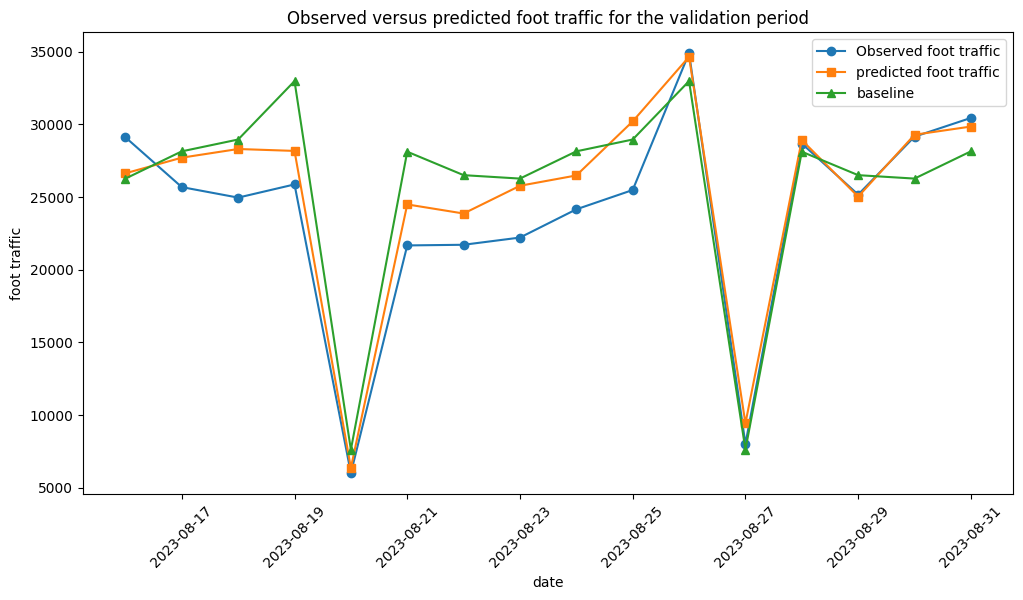

In [37]:
# display observed and predicted total foot traffic
dowma = dfhs[dfhs["month"] == "August"].groupby("dow")["ftraffic"].mean()
y_pred_abs = y_pred + valid_data["dow"].map(dowma)
y_valid_abs = y_valid + valid_data["dow"].map(dowma)
baseline=0+valid_data["dow"].map(dowma)
plt.figure(figsize=(12,6))
plt.plot(valid_data["date"], y_valid_abs, label="Observed foot traffic", marker="o")
plt.plot(valid_data["date"], y_pred_abs, label="predicted foot traffic", marker="s")
plt.plot(valid_data["date"], baseline, label="baseline", marker="^")
plt.xlabel("date")
plt.ylabel("foot traffic")
plt.legend()
plt.xticks(rotation=45)
plt.title("Observed versus predicted foot traffic for the validation period")
plt.show()

In the Figure above the observed and predicted foot traffic for the validation period 15th to 31st August 2023 are shown.
In addition, a baseline time series is displayed, which simply consists of the mean foot traffic for each day of the week
for July and August of 2023 and 2024. Although a rather simple model and only two predictors (tmax_a and rainfall duration)
are used, the predicted foot traffic agrees well to observations. Further, the Random Forest Regressor
model outperforms the "baseline model", despite its simplicity. For example, in the last days of the validation period
the predicted time series closely follows the obeserved time series, while the baseline over-/underestimates the foot traffic.
These results demonstrate the potential of using weather data to predict foot traffic. Testing alternative machine
learning models and using more (complex) features and a longer training period is planned for the future.